In [1]:
import LightGraphs: is_directed, ne, nv, edgetype, edges, vertices,
                    outneighbors, inneighbors, has_vertex, has_edge

using GraphPlot
using BenchmarkTools: @btime
import SNAPDatasets

In [2]:
mutable struct MatrixDiGraph{MT<:AbstractMatrix{Bool}} <: LightGraphs.AbstractGraph{Int}
    m::MT
end

## Methods on the graph

In [3]:
is_directed(::MatrixDiGraph) = true
edgetype(::MatrixDiGraph) = LightGraphs.SimpleGraphs.SimpleEdge{Int}
ne(g::MatrixDiGraph) = sum(g.m)
nv(g::MatrixDiGraph) = size(g.m)[1]

vertices(g::MatrixDiGraph) = 1:nv(g)

function edges(g::MatrixDiGraph)
    n = nv(g)
    return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in 1:n if g.m[i,j])
end

edges (generic function with 3 methods)

## Methods on the graph and node

In [4]:
outneighbors(g::MatrixDiGraph, node) = [v for v in 1:nv(g) if g.m[node, v]]

inneighbors(g::MatrixDiGraph,  node) = [v for v in 1:nv(g) if g.m[v, node]]

has_vertex(g::MatrixDiGraph, v::Integer) = v <= nv(g) && v > 0

has_vertex (generic function with 3 methods)

## Methods on the graph and edge

In [5]:
has_edge(g::MatrixDiGraph, e::LightGraphs.SimpleGraphs.SimpleEdge{Int}) = g.m[src(e),dst(e)]
has_edge(g::MatrixDiGraph,i,j) = g.m[i,j]

has_edge (generic function with 7 methods)

## Optional mutability methods

In [6]:
import LightGraphs: rem_edge!, rem_vertex!, add_edge!, add_vertex!

# return whether insertion succeeds
function add_edge!(g::MatrixDiGraph, e)
    has_edge(g,e) && return false
    n = nv(g)
    (src(e) > n || dst(e) > n) && return false
    g.m[src(e),dst(e)] = true
end

function rem_edge!(g::MatrixDiGraph,e)
    has_edge(g,e) || return false
    n = nv(g)
    (src(e) > n || dst(e) > n) && return false
    g.m[src(e),dst(e)] = false
    return true
end

function add_vertex!(g::MatrixDiGraph)
    n = nv(g)
    m = zeros(Bool,n+1,n+1)
    m[1:n,1:n] .= g.m
    g.m = m
    return true
end

add_vertex! (generic function with 4 methods)

## Crash test for MatrixDiGraph
![](img/firework-new-year-s-eve-rocket-3893.jpg)

### PageRank algorithm

* Easy to grasp
* Concrete applications
* Nice theory behind

Data from the Stanford Network Analysis Project (SNAP)

In [7]:
import SNAPDatasets
data = SNAPDatasets.loadsnap(:ego_twitter_d)

{81306, 1768149} directed simple Int64 graph

In [8]:
import LightGraphs: adjacency_matrix, pagerank
twitter_graph = MatrixDiGraph(adjacency_matrix(data)[1:10,1:10].==1); 

In [9]:
ranks = pagerank(twitter_graph)

10-element Array{Float64,1}:
 0.125202 
 0.125316 
 0.0746437
 0.0811664
 0.118521 
 0.157039 
 0.0887409
 0.103414 
 0.022543 
 0.103414 

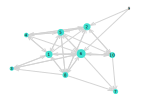

In [10]:
gplot(twitter_graph, nodesize=ranks, nodelabel=1:nv(twitter_graph))

In [11]:
bigger_twitter = MatrixDiGraph(adjacency_matrix(data)[1:500,1:500].==1);
big_ranks = pagerank(bigger_twitter)
gplot(bigger_twitter, nodesize=big_ranks, nodelabel=1:nv(bigger_twitter))

## Overloading non-primitive functions

If your type supports a faster way to do something, use it!

In [12]:
using BenchmarkTools: @btime

@btime adjacency_matrix(bigger_twitter)
println("why did that take so long?")
adjacency_matrix(g::MatrixDiGraph) = Int.(g.m)
@btime A = adjacency_matrix(bigger_twitter)
println("that's better.")

  13.077 ms (5222 allocations: 682.03 KiB)
why did that take so long?
  82.077 μs (6 allocations: 201.77 KiB)
that's better.


-------------------

## Wrap-up

* Design specialized graph types for your needs, you know best!
* Define a couple functions describing behavior
* Use the JuliaGraphs ecosystem for free, build on top 

React, complain, contribute: 
- *github.com/JuliaGraphs*
- Discourse
- Slack `#graphs` channel

## Bonus

One graph type to rule them all

In [26]:
struct GraphMatrix{MT<:AbstractMatrix{Bool}} <: LightGraphs.AbstractGraph{Int64}
    m::MT
    is_directed::Bool
end

# methods on the graph
is_directed(g::GraphMatrix) = g.is_directed
edgetype(::GraphMatrix) = LightGraphs.SimpleGraphs.SimpleEdge{Int64}
ne(g::GraphMatrix) = is_directed(g) ? sum(g.m) : div(sum(g.m),2)
nv(g::GraphMatrix) = size(g.m)[1]

vertices(g::GraphMatrix) = 1:nv(g)

function edges(g::GraphMatrix)
    n = nv(g)
    if g.is_directed
        return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in 1:n if g.m[i,j])
    else
        return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in i+1:n if g.m[i,j])
    end
end

edges (generic function with 4 methods)